# Capstone II: Craiglist Used Car Dataset
### Part 4: Model Development
Biman Mondal

May 26, 2025

This notebook outlines step 4 of the datascience process, model development. This notebook will attempt to create several models with the cleaned dataset (step 1-3) and compare their prediction error. 

The objective of the analysis is to use the dataset to predict vehicle price (target variables) using the other predictor variables in the dataset like vehicle: ('year', 'odometer', 'manufacturer', and 'model').

Original Dataset .csv file downloaded from Kaggle:\
https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

In [78]:
# Import numpy package
import numpy as np
# Import pandas package
import pandas as pd
# Import matplotlib package
import matplotlib.pyplot as plt
# Import the seaborn package
import seaborn as sns

import time
# Future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from functools import cache

# Modeling
#import sklearn.model_selection
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate
# Models
#from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer

In [3]:
# Read Dataframe
vehicles = pd.read_csv('./data/step3_vehicles_processed.csv', header='infer',index_col='id')

### Split dataset
The dataset has been prepared in the previous step and the data is ready to be modeled.
To use prevent the model from overfitting, the data must be split in two; a train dataset and test dataset.

In [4]:
# Define target variable and independent variables
X = vehicles.drop('price',axis=1)
y = vehicles['price'] 

# Split dataset 70% train, 30% Test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,
                                                train_size = 0.70,
                                                random_state = 42)

### 1. Baseline Linear Regression
Use the linear regression as a baseline model.\
Use linear regression from sklearn. 
The R^2 and mean squared error results are similar to that of the statsmodel trial.

In [5]:
#
start_time = time.perf_counter()

# Perform LR with SKlearn
lreg = LinearRegression()
lreg.fit(Xtrain,ytrain)
ypred_lr = lreg.predict(Xtest)

# R^2 for Train/Test values is nearly the same as the stats model
#print(f"Train R^2: {lreg.score(Xtrain, ytrain):.3} \nTest R^2: {lreg.score(Xtest, ytest):.3}")
# Evaluate negative mean squared error
print(f"LR root mean squared error (RMSE): {round(np.sqrt(mean_squared_error(ytest, ypred_lr)),1)}.")
print(f"LR mean absolute error (MAE): {round(mean_absolute_error(ytest, ypred_lr),1)}.")
# Evaluate man absolute percent error
print(f"LR mean absolute percent error (MAPE): {round(MAPE(ytest, ypred_lr),3)}.")
#
end_time = time.perf_counter()
print(f"Elapsed time: {round((end_time - start_time)/60,3)} minutes.")

LR root mean squared error (RMSE): 7293.6.
LR mean absolute error (MAE): 4775.7.
LR mean absolute percent error (MAPE): 0.71.
Elapsed time: 0.01 minutes.


<center>
Root mean square error:
$
\text{RMSE} = \sqrt{\frac{\sum_{i=1}^{N} (P_i - A_i)^2}{N}}
$
<center>

<center> 
Mean absolute percent error:    
$
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{A_i - P_i}{A_i} \right| 
$
<center>

<center> $A_i$ is actual value and $P_i$ is predicted value.<center>
    
*Note that MAPE is scaled producing relative error from 0 to 1. Although stated as percent error, sklearn MAPE requires scaling by 100 to become a percentage.*

#### 1.1 - LR with 5-fold Cross-validation
Cross-validation is a robust method of splitting the dataset to evaluate a model's performance. The data is split into k-splits and traned on k-1 splits and tested on the remainder. The process is repeated for all combination of splits.
    
https://scikit-learn.org/stable/modules/cross_validation.html \
https://machinelearningmastery.com/from-train-test-to-cross-validation-advancing-your-models-evaluation/

In [6]:
#
start_time = time.perf_counter()

# Classification scoring: 'accuracy', 'f1', 'precision', 'recall', 'roc_auc'
# Regression scoring: 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_error'

# Use Cross val score -> only one evaluation metric
#lr = LinearRegression()
#cv_results_lr =  cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')

# Use cross-validate to evaluate multiple scoring metrics
lr = LinearRegression()
scores = cross_validate(lr, X, y, cv=5,
                        scoring=('neg_mean_absolute_percentage_error', 'neg_mean_squared_error'),
                        return_train_score=True)
end_time = time.perf_counter()
print(f"Elapsed time: {round((end_time - start_time)/60,3)} minutes.")

Elapsed time: 0.074 minutes.


In [7]:
# Print score information

#print(scores.keys())
print("5-fold CV multiple evaluation metrics:")

nmse_scores = scores.get('train_neg_mean_squared_error')
print('RMSE:')
print(f"Average: {np.mean(np.sqrt(-nmse_scores)).round(2)}")
print(f"Std. Dev.: {np.std(np.sqrt(-nmse_scores)).round(3)}")

nmape_scores = scores.get('train_neg_mean_absolute_percentage_error')
print('MAPE:')
print(f"Average: {np.mean(np.sqrt(-nmape_scores)).round(2)}")
print(f"Std. Dev.: {np.std(np.sqrt(-nmape_scores)).round(3)}")

end_time = time.perf_counter()

5-fold CV multiple evaluation metrics:
RMSE:
Average: 7248.22
Std. Dev.: 83.72
MAPE:
Average: 0.85
Std. Dev.: 0.014


#### 1.2 - Function to perform cross validation

In [82]:
def perf_cross_val_eval(model, indep, dep, metric):    
    start_time = time.perf_counter()
    
    # Perform 5-fold cross validation
    scores =  cross_validate(model, indep, dep, cv=5, scoring=metric)
    
    avg_test_scores = -scores['test_score']
    stdev_test_scores = -scores['test_score']
    
    print(type(model).__name__,' 5-fold CV Test Scores:')
    print(f"Average: {avg_test_scores.mean().round(2)}")
    print(f"Std. Dev.: {stdev_test_scores.std().round(3)}")
    
    end_time = time.perf_counter()
    print(f"Elapsed time: {round((end_time - start_time)/60,2)} minutes.")
    
    return [avg_test_scores, stdev_test_scores]


MAPE, because it is a scaled number, will be used to evaluate models for the duration of this notebook.\

## 2. Feature Scaling

The dataset includes values of different ranges. Price is in 10's of thousands, the odometer is in the range of 100,000's and the years are in thousand's. Note that One Hot Encoded features are already on the scale of 0 and 1. 


In [9]:
# Transform the numerical data

# Copy dataset and rename scaled
#scaled_vehicles = vehicles.copy()
# Initialize StandardScaler
scaler = StandardScaler()
numeric_cols = ['year','cylinders','odometer']

# Apply standardization to the selected column
scaled_array = scaler.fit_transform(vehicles[numeric_cols])
# Scale Data
df_scaled = pd.DataFrame(scaled_array, columns=numeric_cols, index=vehicles.index)
# Incorporate into single dataframe
scaled_vehicles = pd.concat([df_scaled, vehicles.drop(columns=numeric_cols)], axis=1)


In [10]:
# Plot the normalized data frame
#scaled_vehicles[['year','odometer','cylinders']].hist()
#plt.show()

In [83]:
lr = LinearRegression()
X = scaled_vehicles.drop('price',axis=1)
y = scaled_vehicles['price']
metric = 'neg_mean_absolute_percentage_error'
#scores =  cross_validate(lr, X, y, cv=5, scoring='neg_mean_absolute_percentage_error')
scores = perf_cross_val_eval(lr, X, y, metric)

LinearRegression  5-fold CV Test Scores:
Average: 0.73
Std. Dev.: 0.085
Elapsed time: 0.07 minutes.


### 2.2 - Quantile Transformer

In [12]:
# Apply quantile transformer

num_cols = ['year','cylinders','odometer']
qt = QuantileTransformer(output_distribution='normal', random_state=0)
# Fit transform data
qt_array = qt.fit_transform(vehicles[num_cols])
# Convert array to dataframe
df_scaled = pd.DataFrame(qt_array, columns=num_cols, index=vehicles.index)
# Incorporate scaled data into scaled dataframe
qtscaled_vehicles = pd.concat([df_scaled, vehicles.drop(columns=num_cols)], axis=1)

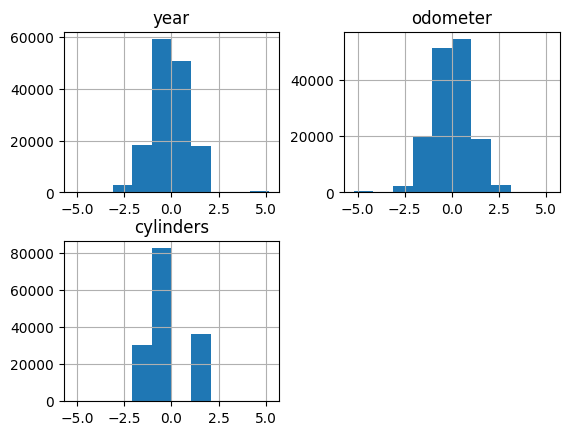

In [13]:
# Plot the normalized data frame
qtscaled_vehicles[['year','odometer','cylinders']].hist()
plt.show()

The quantile transformed data has transformed the data to look like a normal distribution.

In [42]:
lr = LinearRegression()
X_qs = qtscaled_vehicles.drop('price',axis=1)
y_qs = qtscaled_vehicles['price']
lr_qtscale_scores = perf_cross_val_eval(lr, X_qs, y_qs, metric)

LinearRegression  5-fold CV Test Scores:
Average: 0.69
Std. Dev.: 0.079
Elapsed time: 0.07 minutes.


By performing feature scaling with quantile transformer the original average linear regression error has reduced from 0.84 down to 0.69.

## 3. Ridge Regression
Ridge regression is a linear regression analysis with a penalty that prevents models from overfitting to the data. The penalty that ridge regression uses reduces coefficients to zero but does not eliminate them.

In [16]:
# Split dataset using the quantile scaled dataset
# Define target variable and independent variables
X_qs = qtscaled_vehicles.drop('price',axis=1)
y_qs = qtscaled_vehicles['price'] 

# Split dataset 80% train, 20% Test
Xtrain_qs, Xtest_qs, ytrain_qs, ytest_qs = train_test_split(X_qs, y_qs,
                                                train_size = 0.70,
                                                random_state = 42)

In [23]:
#
#start_time = time.perf_counter()

for val in [0.001, 0.1, 10., 100.]:
    print(f'alpha={val}')
    ridreg = Ridge(alpha=val)
    ridge_scores = perf_cross_val_eval(ridreg, X_qs, y_qs, metric)
    
    #ridreg.fit(Xtrain_qs,ytrain_qs)
    #ypred_rid = ridreg.predict(Xtest_qs)
    # The R^2 values is nearly the same as the stats model
    #print(f"Train R^2: {ridreg.score(Xtrain_qs, ytrain_qs):.3} \nTest R^2: {ridreg.score(Xtest_qs, ytest_qs):.3}")
    #print(f"Ridge regression MAPE: {round(MAPE(ytest_qs, ypred_rid),2)}.")
    ridge_scores =[]
    ridreg =[]
#
#end_time = time.perf_counter()
#print(f"Elapsed time: {round((end_time - start_time)/60,3)} minutes.")

alpha=0.001
Ridge  5-fold CV Test Scores:
Average: 0.69
Std. Dev.: 0.079
Elapsed time: 0.03 minutes.
alpha=0.1
Ridge  5-fold CV Test Scores:
Average: 0.69
Std. Dev.: 0.079
Elapsed time: 0.03 minutes.
alpha=10.0
Ridge  5-fold CV Test Scores:
Average: 0.69
Std. Dev.: 0.079
Elapsed time: 0.03 minutes.
alpha=100.0
Ridge  5-fold CV Test Scores:
Average: 0.69
Std. Dev.: 0.08
Elapsed time: 0.03 minutes.


In [24]:
ridreg = Ridge(alpha=0.1)
ridge_scores = perf_cross_val_eval(ridreg, X_qs, y_qs, metric)

Ridge  5-fold CV Test Scores:
Average: 0.69
Std. Dev.: 0.079
Elapsed time: 0.03 minutes.


The results above show that the MAPE increases slightly with increasing alpha with a ridge regression model. So the default alpha=0.1 will be used. With MAPE still at 0.69, thus regularization doesn't have appreciable effect on the model performance.

## 4. Random Forest Regression
Random Forest is an ensemble decision tree machine learning algorithm. It combines multiple individual tree models to create a single aggregate model.

In [46]:
#
#start_time = time.perf_counter()

rf = RandomForestRegressor(n_jobs=-1, random_state=30)
rf_scores = perf_cross_val_eval(rf, X, y, metric)

#rf.fit(Xtrain, ytrain)
#ypred_rf = rf.predict(Xtest)

# Print R^2 for fit
#print("RF - Test R²:", np.round(rf.score(Xtest, ytest),3))
# Mean absolute percentage error
#print(f"RF MAPE: {round(MAPE(ytest, ypred_rf),2)}.")

#
#end_time = time.perf_counter()
#print(f"Elapsed time: {round((end_time - start_time)/60,3)} minutes.")

RandomForestRegressor  5-fold CV Test Scores:
Average: 0.46
Std. Dev.: 0.113
Elapsed time: 2.42 minutes.


The random forest regressor model reduces the error of 0.31; much improved from linear regression.  

#### 4.1 RF with Scaled Data
Random Forest with scaled data did not show any improvement in model error rate. This is expected, as one of the benefits of RM is handling data at multiple scales.

In [ ]:
"""
#
start_time = time.perf_counter()

rf = RandomForestRegressor(n_jobs=-1, random_state=30)
rf.fit(Xtrain_qs, ytrain_qs)
ypred_rf_scaled = rf.predict(Xtest_qs)

# Print R^2 for fit
print("RF - Test R²:", np.round(rf.score(Xtest_qs, ytest_qs),3))
# Mean absolute percentage error
print(f"RF MAPE: {round(MAPE(ytest_qs, ypred_rf_scaled),2)}.")

#
end_time = time.perf_counter()
print(f"Elapsed time: {round((end_time - start_time)/60,3)} minutes.")
"""

#### 4.2 - RF Grid Search CV

Certain models have multiple parameters. Grid search is a method to run a set of parameters for a given model to find the best combination. The optimum performing parameters for the model are then used for the model. 

https://www.kaggle.com/code/pythonafroz/step-by-step-guide-to-gridsearchcv

In [85]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [None],
    'min_samples_leaf': [1, 5],
    'max_features': [None]
}

rf = RandomForestRegressor(n_jobs=-1, random_state=30)
# Grid search CV defaults to a kFold = 5
grid_rf = GridSearchCV(estimator=rf, cv = 5, 
                           param_grid=params, 
                           n_jobs=-1, verbose=1, scoring='neg_mean_absolute_percentage_error')

grid_rf.fit(X, y)
# Get the best parameters and score
print("Best parameters found: ", grid_rf.best_params_)
print("Best cross-validation score: ", round(grid_rf.best_score_,3))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters found:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1}
Best cross-validation score:  -0.465


### 5. KNN regression
K-nearest neighbors algorithm uses eulidean distance between points to make a prediction. There is a single parameter, the number of neighbors k.

In [45]:
# Set k=2
knn = KNeighborsRegressor(n_neighbors=2)
knn_scores = perf_cross_val_eval(knn, X, y, metric)

"""
knn.fit(Xtrain, ytrain)
ypred_knn = knn.predict(Xtest)

# Print R^2 for fit
print("KNN Train R²:", np.round(knn.score(Xtrain, ytrain),3))
print("KNN Test R²:", np.round(knn.score(Xtest, ytest),3))
# Mean absolute percentage error
print(f"KNN MAPE:", {round(MAPE(ytest, ypred_knn),3)})
"""

KNeighborsRegressor  5-fold CV Test Scores:
Average: 0.49
Std. Dev.: 0.108
Elapsed time: 1.13 minutes.


'\nknn.fit(Xtrain, ytrain)\nypred_knn = knn.predict(Xtest)\n\n# Print R^2 for fit\nprint("KNN Train R²:", np.round(knn.score(Xtrain, ytrain),3))\nprint("KNN Test R²:", np.round(knn.score(Xtest, ytest),3))\n# Mean absolute percentage error\nprint(f"KNN MAPE:", {round(MAPE(ytest, ypred_knn),3)})\n'

#### 5.1 GridSearch with KNN

In [59]:
#
start_time = time.perf_counter()

k_range = list(1, 2, 10, 20)
param_grid = dict(n_neighbors=k_range)
metric = 'neg_mean_absolute_percentage_error'

grid_knn = GridSearchCV(KNeighborsRegressor(n_jobs=-1), param_grid,
                        cv=5, scoring=metric, return_train_score=False, n_jobs=-1)
grid_knn.fit(X, y)
# Get the best parameters and score
print("Best parameters found: ", grid_knn.best_params_)
print("Best cross-validation score: ", round(grid_knn.best_score_,3))

#
end_time = time.perf_counter()
print(f"Elapsed time: {round((end_time - start_time)/60,3)} minutes.")

Best parameters found:  {'n_neighbors': 2}
Best cross-validation score:  -0.485
Elapsed time: 5.436 minutes.


The optimum number for K for this model has been found to be 2 using gridsearch cv.
Using scaled data does not help find the maximum error rate.

## 6. Support Vector Regression

SVR model had long run time and did not have improvement in error from the other models.

In [ ]:
"""
start_time = time.perf_counter()

#svr = SVR(kernel='rbf', C=0.1, epsilon=0.2)
svr = SVR(max_iter=1000)
svr.fit(Xtrain, ytrain)
ypred_svm = svr.predict(Xtest_sc)
# The R^2 values is nearly the same as the stats model
print(f"Train R^2: {svr.score(Xtrain_sc, ytrain_sc):.3} \nTest R^2: {svr.score(Xtest_sc, ytest_sc):.3}")
print(f"Support Vector Regression mean absolute percent error is: {round(MAPE(ytest_sc, ypred_svm),2)}.")

#
end_time = time.perf_counter()
print(f"Elapsed time: {round((end_time - start_time)/60,3)} minutes.")
"""

## 7. Gradient Boosing Regressor


In [ ]:
#
start_time = time.perf_counter()
# Create the parameter grid for Gradient Boosting Regressor
params = {
    'max_depth': [10, 20],
    'learning_rate': [0.2, ],
    'alpha': [.1,],
}
# model
gbt = GradientBoostingRegressor(random_state=30)
#print(gbt.get_params())
# Grid search CV defaults to a kFold = 5
grid_gbt = GridSearchCV(estimator=gbt, cv = 5, 
                           param_grid=params, 
                           n_jobs=-1, verbose=1, scoring='neg_mean_absolute_percentage_error')
# fit

grid_gbt.fit(X, y)
# Get the best parameters and score
print("Best parameters found: ", grid_gbt.best_params_)
print("Best cross-validation score: ", round(grid_gbt.best_score_,3))
#
end_time = time.perf_counter()
print(f"Elapsed time: {round((end_time - start_time)/60,3)} minutes.")

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
gbt = GradientBoostingRegressor(alpha= 0.1, learning_rate=0.2, max_depth=10, random_state=40)
gbt_scores = perf_cross_val_eval(gbt, X, y, metric)

GradientBoostingRegressor  5-fold CV Test Scores:
Average: 0.5
Std. Dev.: 0.095
Elapsed time: 9.26 minutes.


[array([0.5327742 , 0.45919027, 0.36496684, 0.65690461, 0.50016721]),
 array([0.5327742 , 0.45919027, 0.36496684, 0.65690461, 0.50016721])]

## 8. Stochastic Gradient Regressor

In [74]:
from sklearn.linear_model import SGDRegressor

In [75]:
# Create the parameter grid based on the results of random search 
params = {
    'learning_rate': ['adaptive'],
    'alpha': [0.1, 0.2],
    'epsilon': [0.1, 0.2]
}

sgd = SGDRegressor(random_state=30)
print(sgd.get_params())

# Grid search CV defaults to a kFold = 5
grid_sgd = GridSearchCV(estimator=sgd, cv = 5,
                        param_grid=params, 
                        n_jobs=-1, verbose=1, scoring='neg_mean_absolute_percentage_error')

grid_sgd.fit(X, y)
# Get the best parameters and score
print("Best parameters found: ", grid_sgd.best_params_)
print("Best cross-validation score: ", round(grid_sgd.best_score_,3))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'alpha': 0.1, 'epsilon': 0.1, 'learning_rate': 'adaptive'}
Best cross-validation score:  -0.746


In [ ]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(alpha=0.1,learning_rate='adaptive', random_state=30)
sgd_results = perf_cross_val_eval(sgd, X, y, metric)


### 9. Summarize Model Results

In [48]:
# Combine results into a dataframe
resdf = pd.DataFrame(columns=['Linear Regression','Ridge Regression','Random Forest','KNN'])
resdf.iloc[:,0] = lr_qtscale_scores[0]
resdf.iloc[:,1] = ridge_scores[0]
resdf.iloc[:,2] = rf_scores[0]
resdf.iloc[:,3] = knn_scores[0]
resdf

,Linear Regression,Ridge Regression,Random Forest,KNN
0,0.666440,0.666429,0.539987,0.56446
1,0.672493,0.672494,0.449627,0.478898
2,0.579802,0.579798,0.318246,0.332896
3,0.818682,0.818611,0.635611,0.64456
4,0.736185,0.736167,0.380126,0.423615


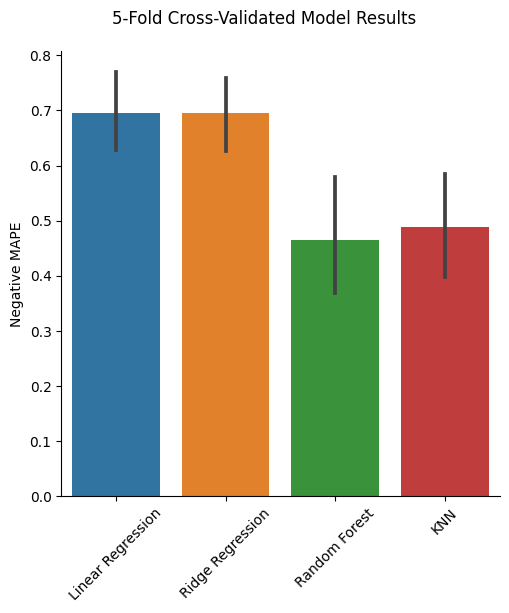

In [49]:
#
g = sns.catplot(data=resdf,kind='bar')
g.fig.suptitle('5-Fold Cross-Validated Model Results', y=1.05)
#ax = g.facet_axis(0, 0)
#g.bar_label(g.containers[0], labels=resdf.mean())
plt.ylabel('Negative MAPE')
g.tick_params(axis='x', labelrotation=45)
plt.show()

### Summary

This notebook has developed several machine learning models using the sci-kit learn library on the used car dataset to predict the price of a given used vehicle. Negative mean absolute percent error metric was used to compare the model performance is  because it is an intuitive percentage. Since the price is listed in the thousands, the mean squared error leads to a large value. A 5-fold cross validation was performed for each model to determine the variance of the model. A plot of the 5-fold cross validation shows that Random Forest Regression performed the best on average with predicting price however it also took the longest to run. 

Linear regression results are satisfactory and was the fastest to run.  In an effort to improve the linear regression results, the numerical data (year, odometer, and cylinders) were normalized to scale using 'PowerTransformer'. Unfortuantely, this did not have an appreciable effect on reducing the error from.

The Random Forest without specifying parameters (depth, number of estimators) takes the longest to run on the full model but also has the best results. A gridsearch was performed on the KNN model and found the k=1 neighbors yielded minimum error. KNN is the intermediate model, which takes a little longer than the linear regression but also produces lower error than the linear/ridge regression. 

